# Online Shoppers Purchasing Intention

Chien-Lan Hsueh (chsueh2@ncsu.edu)

## Task 1: Introduction

The main goal of the notebook is to explore and fit supervised learning models using the [Online Shoppers Purchasing Intention Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) dataset from UCI Machine Learning Repository. 

### Data Set Information:
The dataset consists of feature vectors belonging to 12,330 website visit sessions of online shoppers. Each session belongs to a different user in a 1-year period "to avoid any tendency to a specific campaign, special day, user profile, or period."

### Attribute Information:
According to the repository website descriptions, the data set has a total of 12330 observations, and 18 variables including 17 prdictors (10 numerical and 7 categorical) and 1 binary response:  

#### Predictors
The first 6 numerical variables represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories:
- 1. `Administrative`: number of Administrative pages visited
- 2. `Administrative_Duration`: visit duration on Administrative pages
- 3. `Informational`: number of Informational pages visited
- 4. `Informational_Duration`: visit duration on Informational pages
- 5. `ProductRelated`: number of Product Related pages visited
- 6. `ProductRelated_Duration`: visit duration on Product Related pages

The next 3 numerical variables arepresent the metrics measured by "Google Analytics" for each page in the e-commerce site:
- 7. `BounceRates`: the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session.
- 8. `ExitRates`: calculated as for all pageviews to the page, the percentage that were the last in the session. 
- 9. `PageValues` represents the average value for a web page that a user visited before completing an e-commerce transaction.

And one numeric variable to represent how close the visit time to a specific day:
- 10. `SpecialDay`, indicates the closeness of the site visiting time to a specific special day (e.g. Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12:
    - `SpecialDay = 0`: before and after this date unless it is close to another special day
    - `SpecialDay = 1`: its maximum value on Valentine's Day (February 8 of the year of this study)

There are 7 categorical variables in which some of them are coded in numbers:
- 11. `Month`: month of the year (coded in string)
- 12. `OperatingSystems`: operating system visitor used (coded in numbers)
- 13. `Browser`: browser visitor used (coded in numbers)
- 14. `Region`: visitor's physical region (coded in numbers)
- 15. `TrafficType`: traffic type (coded in numbers)
- 16. `VisitorType`: visitor type - new visitor, returning or others (coded in string)
- 17. `Weekend`: indicates whether the date of the visit is weekend (Boolean)

#### Response
- 18. `Revenue`: a Boolean value, which can be used as a class label, thus were used as the classification outcome variable in our models for this project. According to the data description, of the 12,330 sessions in the dataset, 84.5% (10,422) were negative class samples that did not end with shopping (`Revenue` = `FALSE`), and the rest (1908) were positive class samples ending with shopping (`Revenue` = `TRUE`). 

### Our analysis plan
1. EDA:
    We first conduct EDA only on the **training set** through `spark SQL` (and/or `pandas-on-spark`) to get a good understanding of the data structure and the direction and magnitude of association between the variables (columns) of the data set, which provides us with a good overview of the relationship amongst variables, and help us identify the useful predictors to be included in the models, especially the ones that reply less on machine-learning approaches but more on theory or traditional EDA results, such as logistic regression class of models.
    - For numeric variables: inspect collinearity and determine which to include in logistic regression
    - For categorical variables: recode the variable if the data distribution is imbalanced
2. Machine learning models:
    We then fit three different models including **logistic regression** and two tree-based classification models (**decision tree classifier** and **random forest classifier**) using area under ROC curve as our model selection metric (`evaluator`)

### Reference:
1. Source: [UCI Machine Learning Repository: Online Shoppers Purchasing Intention Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset)
2. Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Real-time prediction of online shoppers’ purchasing intention using multilayer perceptron and LSTM recurrent neural networks. [Neural Computing and Applications volume 31, pages6893–6908 (2019)](https://doi.org/10.1007/s00521-018-3523-0)
    The paper also provides more inforamtion about the study utilizing this data for real-time prediction of online shoppers' purchasing intention using multilayer perceptron and LSTM recurrent nueral networks.


## Task 2: Supervised Learning Idea and Data Split Questions and Answers

1. Why we want to, what we are generally trying to do with supervised learning where prediction is our goal?
    Supervised learning is a type of machine learning approach that uses labeled datasets to train algorithms for the purpose of classifying or predicting outcomes accurately. The modeling process adjust weights ane tune the parameters via cross validation process, which helps to determining the best model. The supervised learning approach automates the the parameter tuning process and selects the best performing model using the training data, thus frees the analysts or researchers from manually trying different models that contain varying combinations of predictors. Such automatic machine learning approach is particularly more advantageous than manual tryout of modelings when dealing with big data sets that contain tens, hundreds, and thousands of variables can be considered predictors.  

2. Why we want to split our data into a training and test set?
    We want to split the data into a training and test set to avoid overfitting the model based on a single data. We select the best model based on certain prediction criterion (often accuracy or loss etc) using the training set. However, the best model for the training set may or may not fit well using a different set of data. By splitting the data into a training and test set, we simulate the opportunity to test if the model is still robust and achieve acceptable level of prediction accuracy given another sample presumably from the same population. Thus, it is very important to split the data sets before we do any time of modeling, and before the EDA process. 

## Task 3: EDA
- Preparation
    - Load modules needed and set up environments
    - Establish spark session and read in data
        - check schema and inspect the data
        - check if there is any null values
    - Create training and test data split
- EDA using the Training Set
    - Summaries stats for numeric predictors
    - Association analysis:
        - Correlations between independent variables and bewteen the response and independent variables
        - Determine which variables to include in logoistic regression model   
    - Check observation balance (across categorical variables)
        - Recode imbalanced variables

### Preparation
#### Load modules and set up environments

In [1]:
# import the modules
import os, sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps
ps.options.plotting.backend = "matplotlib"

from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import SQLTransformer, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Establish spark session and read in data

In [2]:
# create a spark session
spark = SparkSession.builder.getOrCreate()

In [3]:
# read in the data
df_raw = spark.read.csv(
    path = "online_shoppers_intention.csv",
    sep = ",",
    header = True,
    inferSchema = True,
    )

# show the schema of the dataframe
df_raw.printSchema()

# take a look at the data (the first 5 rows) - terrible look
#df_raw.show()

# take a look at the data (the first 5 rows) - print nicely by converting to pandas dataframe
display(df_raw.limit(5).toPandas().rename(index = lambda x: "row " + str(x)).transpose())

# check if there is any null values
df_raw \
    .select([count(when(col(c).isNull(), c)).alias(c) for c in df_raw.columns]) \
    .toPandas() \
    .rename(index = {0: "# of Null Values"}) \
    .transpose()

root
 |-- Administrative: integer (nullable = true)
 |-- Administrative_Duration: double (nullable = true)
 |-- Informational: integer (nullable = true)
 |-- Informational_Duration: double (nullable = true)
 |-- ProductRelated: integer (nullable = true)
 |-- ProductRelated_Duration: double (nullable = true)
 |-- BounceRates: double (nullable = true)
 |-- ExitRates: double (nullable = true)
 |-- PageValues: double (nullable = true)
 |-- SpecialDay: double (nullable = true)
 |-- Month: string (nullable = true)
 |-- OperatingSystems: integer (nullable = true)
 |-- Browser: integer (nullable = true)
 |-- Region: integer (nullable = true)
 |-- TrafficType: integer (nullable = true)
 |-- VisitorType: string (nullable = true)
 |-- Weekend: boolean (nullable = true)
 |-- Revenue: boolean (nullable = true)



,row 0,row 1,row 2,row 3,row 4
Administrative,0,0,0,0,0
Administrative_Duration,0.0,0.0,0.0,0.0,0.0
Informational,0,0,0,0,0
Informational_Duration,0.0,0.0,0.0,0.0,0.0
ProductRelated,1,2,1,2,10
ProductRelated_Duration,0.0,64.0,0.0,2.666667,627.5
BounceRates,0.2,0.0,0.2,0.05,0.02
ExitRates,0.2,0.1,0.2,0.14,0.05
PageValues,0.0,0.0,0.0,0.0,0.0
SpecialDay,0.0,0.0,0.0,0.0,0.0


,# of Null Values
Administrative,0
Administrative_Duration,0
Informational,0
Informational_Duration,0
ProductRelated,0
ProductRelated_Duration,0
BounceRates,0
ExitRates,0
PageValues,0
SpecialDay,0


####  Create training and test data split
As discussed above, we will firsst split the data set into a training set and a test set. We use the `randomSplit()` method on a spark SQL style data frame. Seed is set as 1 for reproductibility. 80% of the original data is randomly assigned as training set and the remining 20% is assigned for test purpose.

In [4]:
# a helper function to describe the train/test sets' dimension and variable groups
def train_test_info(title, df_train, df_test, cols_response, cols_num, cols_cat):
    """
    """
    # get row counts from the train/test splits     
    counts_splits = [df_train.count(), df_test.count()]
    
    # print the info
    print(
        f"{title}:\n"
        f"There are {np.sum(counts_splits)} rows and {len(cols_response + cols_num + cols_cat)} columns.\n"
        f"\tNew train set: {counts_splits[0]} observations.\n"
        f"\tNew test set: {counts_splits[1]} observations.\n"
        f"Response variable: {cols_response}\n"
        f"Numeric variables: {cols_num}\n"
        f"Categorical variables: {cols_cat}")

In [5]:
# split the data into a training and test sets
train, test = df_raw.randomSplit([0.8, 0.2], seed = 1)

# assign column groups - response, numeric predictors and categorical predictors
cols = df_raw.columns
cols_response, cols_num, cols_cat = [cols[-1]], cols[:10], cols[10:-1]

# print out the train/test sets' info
train_test_info("The data set", train, test, cols_response, cols_num, cols_cat)

The data set:
There are 12330 rows and 18 columns.
	New train set: 9890 observations.
	New test set: 2440 observations.
Response variable: ['Revenue']
Numeric variables: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
Categorical variables: ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']


### EDA on train set

In [6]:
# Convert the train set to a pandas-on-Spark dataframe so that we can take advantage of pandas-on-Spark features
ps_train = train.to_pandas_on_spark()
ps_train.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 9890 entries, 0 to 9889
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           9890 non-null   int32  
 1   Administrative_Duration  9890 non-null   float64
 2   Informational            9890 non-null   int32  
 3   Informational_Duration   9890 non-null   float64
 4   ProductRelated           9890 non-null   int32  
 5   ProductRelated_Duration  9890 non-null   float64
 6   BounceRates              9890 non-null   float64
 7   ExitRates                9890 non-null   float64
 8   PageValues               9890 non-null   float64
 9   SpecialDay               9890 non-null   float64
 10  Month                    9890 non-null   object 
 11  OperatingSystems         9890 non-null   int32  
 12  Browser                  9890 non-null   int32  
 13  Region                   9890 non-null   int32  
 14  TrafficType          

#### EDA of Numerical Variables
We perform the following analysis on the numerical variables to help us determin which are useful to be included in our model:
- statistical summary
- mean by repsonse group `Revenue`
- correlation analysis

In [7]:
# statistics summary of numeric predictors
ps_train[cols_num + cols_response] \
    .groupby(cols_response) \
    .describe() \
    .set_index(("Administrative", "count"), append = True) \
    .swaplevel(axis = 1) \
    .drop(columns = "count", axis = 1) \
    .swaplevel(axis = 1) \
    .rename_axis(index = {('Administrative', 'count'): "count"}) \
    .transpose()

Revenue                               True         False
count                               1534.0        8356.0
Administrative          mean      3.417210      2.129248
                        std       3.739476      3.211820
                        min       0.000000      0.000000
                        25%       0.000000      0.000000
                        50%       2.000000      0.000000
                        75%       5.000000      3.000000
                        max      26.000000     27.000000
Administrative_Duration mean    121.411365     74.058741
                        std     203.697882    172.671677
                        min       0.000000      0.000000
                        25%       0.000000      0.000000
                        50%      55.000000      0.000000
                        75%     150.500000     83.000000
                        max    2086.750000   3398.750000
Informational           mean      0.827249      0.459071
                        std       1.573430      1.229743
                        min       0.000000      0.000000
                        25%       0.000000      0.000000
                        50%       0.000000      0.000000
                        75%       1.000000      0.000000
                        max      12.000000     24.000000
Informational_Duration  mean     60.456725     30.541436
                        std     175.519889    137.210903
                        min       0.000000      0.000000
                        25%       0.000000      0.000000
                        50%       0.000000      0.000000
                        75%      23.750000      0.000000
                        max    1767.666667   2549.375000
ProductRelated          mean     48.257497     28.495213
                        std      58.115813     40.002751
                        min       0.000000      0.000000
                        25%      15.000000      6.000000
                        50%      29.000000     16.000000
                        75%      57.000000     35.000000
                        max     534.000000    705.000000
ProductRelated_Duration mean   1895.686771   1057.979564
                        std    2347.153740   1807.846199
                        min       0.000000      0.000000
                        25%     549.083333    150.866667
                        50%    1124.916667    507.833333
                        75%    2269.900000   1320.189881
                        max   27009.859430  63973.522230
BounceRates             mean      0.004989      0.025531
                        std       0.011548      0.052270
                        min       0.000000      0.000000
                        25%       0.000000      0.000000
                        50%       0.000000      0.004167
                        75%       0.006349      0.020000
                        max       0.200000      0.200000
ExitRates               mean      0.019417      0.047503
                        std       0.016022      0.051555
                        min       0.000000      0.000000
                        25%       0.009524      0.015537
                        50%       0.015873      0.028571
                        75%       0.025000      0.054167
                        max       0.200000      0.200000
PageValues              mean     26.953544      1.974262
                        std      33.510762      9.099796
                        min       0.000000      0.000000
                        25%       3.512853      0.000000
                        50%      16.774168      0.000000
                        75%      40.423276      0.000000
                        max     361.763742    246.758590
SpecialDay              mean      0.021904      0.068933
                        std       0.119097      0.209726
                        min       0.000000      0.000000
                        25%       0.000000      0.000000
                        50%       0.000000      0.000000
          

When comparing the means of the numeric variables, we can clearly see that to have purhcase happened (`Revenue = True`):
1. More number of visited pages and longer visiting durations (`Administrative`, `Administrative_Duration`, `Informational`, `Informational_Duration`, `ProductRelated`, `ProductRelated_Duration`) and higher `PageValues` associated to the pages
2. Lower `BounceRates`, `ExitRates` and `SpecialDay`

We then look at the correlation between all the numerical variables and the Revenue. We created a matrix so that we can not only have an idea about the relationship between Revenue and each numerical predictor candidates, but also have an overview of the correlation amongst all the predictors. If one one predictor is strongly correlated with one or more predictors, then we might consider just include one of these predictors for the parsimony of the model as well as avoding collinearity issues.

To help with such review of relationship, we create a matrix as well as a plot to visualize the relationship of the variables.

In [8]:
# Pearson correlation matrix of numerica variable and response
corr = ps_train[cols_num + cols_response].corr().round(decimals = 2)
display(corr)

# visualize the correlation by display it as a heatmap table
corr.style.background_gradient(cmap = "coolwarm").set_precision(2)

C:\Users\clh82\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
Administrative,1.00,0.60,0.38,0.25,0.43,0.37,-0.22,-0.32,0.10,-0.10,0.14
Administrative_Duration,0.60,1.00,0.31,0.25,0.29,0.36,-0.14,-0.20,0.07,-0.07,0.10
Informational,0.38,0.31,1.00,0.62,0.37,0.39,-0.12,-0.16,0.05,-0.05,0.10
Informational_Duration,0.25,0.25,0.62,1.00,0.29,0.36,-0.07,-0.11,0.03,-0.03,0.08
ProductRelated,0.43,0.29,0.37,0.29,1.00,0.86,-0.21,-0.30,0.06,-0.03,0.16
ProductRelated_Duration,0.37,0.36,0.39,0.36,0.86,1.00,-0.18,-0.25,0.06,-0.04,0.16
BounceRates,-0.22,-0.14,-0.12,-0.07,-0.21,-0.18,1.00,0.91,-0.12,0.07,-0.15
ExitRates,-0.32,-0.20,-0.16,-0.11,-0.30,-0.25,0.91,1.00,-0.18,0.10,-0.21
PageValues,0.10,0.07,0.05,0.03,0.06,0.06,-0.12,-0.18,1.00,-0.07,0.50
SpecialDay,-0.10,-0.07,-0.05,-0.03,-0.03,-0.04,0.07,0.10,-0.07,1.00,-0.09


C:\Users\clh82\AppData\Local\Temp\ipykernel_12960\3452683297.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap = "coolwarm").set_precision(2)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue
Administrative,1.00,0.60,0.38,0.25,0.43,0.37,-0.22,-0.32,0.10,-0.10,0.14
Administrative_Duration,0.60,1.00,0.31,0.25,0.29,0.36,-0.14,-0.20,0.07,-0.07,0.10
Informational,0.38,0.31,1.00,0.62,0.37,0.39,-0.12,-0.16,0.05,-0.05,0.10
Informational_Duration,0.25,0.25,0.62,1.00,0.29,0.36,-0.07,-0.11,0.03,-0.03,0.08
ProductRelated,0.43,0.29,0.37,0.29,1.00,0.86,-0.21,-0.30,0.06,-0.03,0.16
ProductRelated_Duration,0.37,0.36,0.39,0.36,0.86,1.00,-0.18,-0.25,0.06,-0.04,0.16
BounceRates,-0.22,-0.14,-0.12,-0.07,-0.21,-0.18,1.00,0.91,-0.12,0.07,-0.15
ExitRates,-0.32,-0.20,-0.16,-0.11,-0.30,-0.25,0.91,1.00,-0.18,0.10,-0.21
PageValues,0.10,0.07,0.05,0.03,0.06,0.06,-0.12,-0.18,1.00,-0.07,0.50
SpecialDay,-0.10,-0.07,-0.05,-0.03,-0.03,-0.04,0.07,0.10,-0.07,1.00,-0.09


As shown in the numric matrix and figure above, the Top 5 numerical predictors of `Revenue` appears to be the following:
1. `PageValues` (r=0.50), 
2. `ExitRates` (r=-0.21), 
3. `ProductRelated` (r=0.16), 
4. `ProductRelated_Duration` (r=0.16) and
5. `BounceRates` (r=-0.15).

Furthermore, given `ExitRates` and `BounceRates` are highly correlated (r=0.91), we can just leave `BounceRates` out from the model. Similarly, we remove`ProductRelated_Duration` from the model because it is highly correlated with `ProductRelated` (r= 0.86).

Thus, we identified the top 3 numerical predictors of `Revenue` to be included in our logistic regression model: 
1. `PageValues`
2. `ExitRates` 
3. `ProductRelated`

#### EDA of Categorical Variables
For the categorical variables, we create cross tables to help us assess the association their relationship with the response `Revenue` and  inspect if the distributions are balanced or not. 

For those which have few counts in certain levels (groups), we will relevel (regroup) and save them as new categorical variables. 

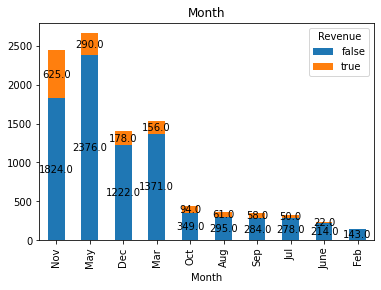

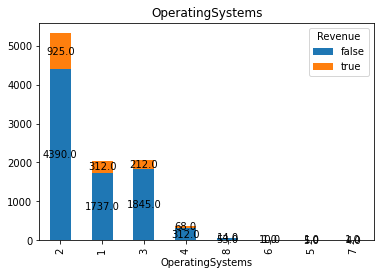

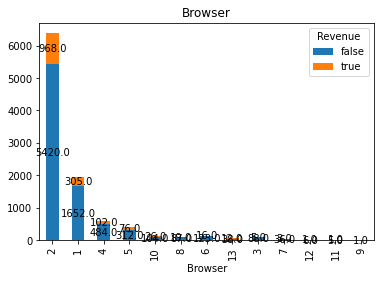

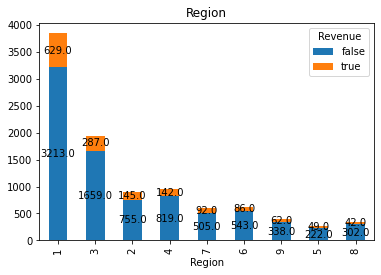

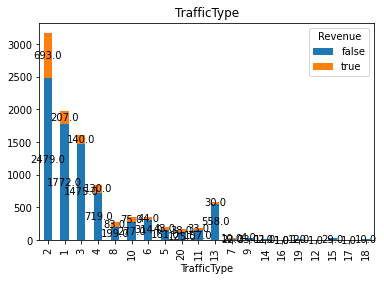

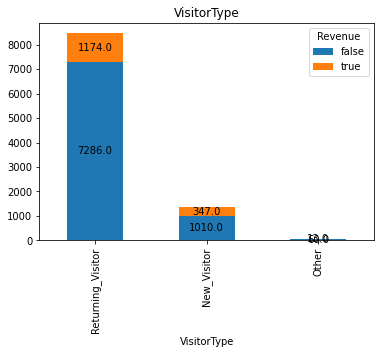

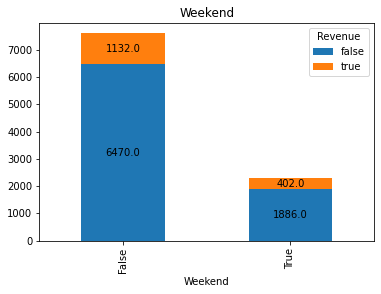

In [9]:
# create cross tables and plot stacked bar charts to inspect the distributions of categorical predictors by response
for x in cols_cat:
    df_tmp = ps_train.groupby(x)[cols_response[0]].value_counts().unstack(level = 1).sort_values(by = "true", ascending = False)
    
    ax = df_tmp.plot.bar(title = x, xlabel = x, stacked=True)    
    for c in ax.containers:
        # Optional: if the segment is small or 0, customize the labels
        labels = [v.get_height() if v.get_height() > 0 else '' for v in c]    
        # remove the labels parameter if it's not needed for customized labels
        ax.bar_label(c, labels = labels, label_type = "center")
    plt.show()

From the bar charts above, we observed that some variables have many categories while some categories only have a tiny sample. Such small samples in certian levels may cause several issues: 1) cases of those levels that have tiny samples may only be assigned to either train or test set during the random split process, or to only one or two of the folds in the cross valiation process; 2) the sample of certain levels can be too small for the logistic regression to converge, and 3) inferences based on the results from the models using tiny samples. Therefore, we decided to combine some levels of most of the categorical variables based on these EDA findings.

Based on the information above, we decide to relevel the following new variables in order to perform our chi square analysis. The justificaiton of our decision of releveling these variable are decribed below:
1. `Quarter` was created to recode `Month` by grouping months of the same seasons
2. `IsMajorOS` was created to recode `OperatingSystems`: 
    - lable 1 through 3 as najor operating systems
    - 4 through 8 appear to be unpopular operating systems that are of small samples
3. `IsPopularBrowser` was created to recode `Browser`:
    - combine 1 and 2 as popular browsers
    - group the rest (3 through 13) as not-so-popular browsers
4. `IsPopularTrafficType` was created to recode `TrafficType`: 
    - popular traffic type (1 through 4)
    - group the rest (5 through 18) as not-so-popular browsers
5. `IsReturingVisitor` was created to recode `VisitorType`: 
    - group the other two levels because `VisitorType = "Returning_Visitor"` dominates

Also since Spark's chi-square test involves `vectorassembler()` process which does not recognize String or Boolean, we have to convert the Boolean variables into integers for it to work [[Reference]](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.stat.ChiSquareTest.html):
1. `Weekend`: casted as an interger
2. `Revenue`: casted as an interger

We define a helper function to recode those categorical variables with imbalanced data distribution. 

In [10]:
# herlp function to recode the selected categorical variables and convert boolean variables to integers
def df_recode(df):
     """
     A helper function to recode the selected categorical variables and convert boolean variables to integers
     df: pyspark dataframe
     """
     new_df = df \
          .withColumn(
               "Quarter", 
               when(col("Month").isin(["Jan","Feb","Mar"]), 1) \
               .when(col("Month").isin(["Apr","May","Jun"]), 2) \
               .when(col("Month").isin(["Jul","Aug","Sep"]), 3) \
               .otherwise(4)) \
          .withColumn(
               "IsMajorOS", 
               when(col("OperatingSystems").isin(["1", "2", "3"]), 1) \
               .otherwise(0)) \
          .withColumn(
               "IsPopularBrowser", 
               when(col("Browser").isin(["1", "2"]), 1) \
               .otherwise(0)) \
          .withColumn(
               "NewTrafficType", 
               when(col("TrafficType").isin(["1"]), 1) \
               .when(col("TrafficType").isin(["2"]), 2) \
               .when(col("TrafficType").isin(["3"]), 3) \
               .when(col("TrafficType").isin(["4"]), 4) \
               .otherwise(5)) \
          .withColumn(
               "IsReturningVisitor", 
               when(col("VisitorType").isin(["Returning_Visitor"]), 1) \
               .otherwise(0)) \
          .withColumn("Weekend", train.Weekend.cast('integer')) \
          .withColumn("Revenue", train.Revenue.cast('integer'))
     
     return new_df

We then use the above helper function to recode the train dataset and perform a chi square tests to assess the association between `Revenue` and the recoded categorical variables for the purpose of identifying the best categorical predictors of `Revenue` to be used in the logistic regression method:

In [11]:
# convert the train set with recoded variables
new_train = df_recode(train)

# update the list of categorical columns with recoded variables
cols_cat_recoded = ["Quarter", "IsMajorOS", "IsPopularBrowser", "Region", "NewTrafficType", "IsReturningVisitor", "Weekend"]

# perform a chisqure test on the releveled categorical variables
assembler = VectorAssembler() \
    .setInputCols(cols_cat_recoded) \
    .setOutputCol("features")

ChiSquareTest.test(assembler.transform(new_train ), "features", "Revenue", True).orderBy("featureIndex").show()

C:\Users\clh82\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------------+--------------------+----------------+------------------+
|featureIndex|              pValue|degreesOfFreedom|         statistic|
+------------+--------------------+----------------+------------------+
|           0|                 0.0|               3|172.01197532049187|
|           1|  0.1092324875744124|               1| 2.565290540259333|
|           2| 0.10220034961365387|               1| 2.670866782420976|
|           3|  0.2992979830604626|               8|  9.53359248608237|
|           4|                 0.0|               4|193.84893330095107|
|           5|                 0.0|               1|119.14157322468888|
|           6|0.001911663892910...|               1| 9.632479230932113|
+------------+--------------------+----------------+------------------+



From the p-values, we found that
- `Quarter` (featureIndex=0)
- `NewTrafficType` (featureIndex=4)
- `IsReturningVisitor` (featureIndex=5)
- `Weekend` (featureIndex=6) 

are significantly associated with `Revenue`. Thus, we will include these categorical variables in our model.

In [12]:
# save the indexes of selected categorical variables
lst_idx = [0, 4, 5, 6]

### Predictor selection and final data prepartion (on the test set)

To summarize, our EDA helps us to achieve two main goals:
1. To review the data and prepare the data for better modeling process, especially handling the small sample issues that happened to quite a few categorical variables. This data preparation is critical to all of the three methods of modeling we will show in Task 4.
2. To help us identify potential predictors for our label variable (i.e.`Revenue`) to be included in the logistic regression modeling. This EDA goal is not that important for classification tree and random forest because they are machine learning approaches select the best predictors and their interaction terms via parameter tuning. However, determining the association between variables by evaluating correlation is critical to the logistic regression modeling method.

With the EDA, we have identified 7 predictors (3 numerical variables and 4 categorical variables) and 1 binary response variable to be included in our logistic regression modeling: 
- Numerical predictors
    1. `PageValues`
    2. `ExitRates`
    3. `ProductRelated`
- Categorical predictors    
    1. `Quarter` : converted from `Month` (["Jan","Feb","Mar"] -> 1, ["Apr","May","Jun"] -> 2, ["Jul","Aug","Sep"] -> 3, Otherwise -> 4 )
    2. `NewTrafficType`: converted from `TrafficType` (keeping the original "1", "2", "3", "4" and grouping all the others to "5")
    3. `IsReturningVisitor`: converted from `VisitorType`, returning visitors or not
    4. `Weekend`
- Response variable - `Revenue`

And we will include all variables in our tree-based models.

In [13]:
# assign columns groups for logistic regression model
lrcols_num = ["PageValues", "ExitRates", "ProductRelated"]
lrcols_cat = [cols_cat_recoded[x] for x in lst_idx]

# convert the train set with recoded variables
new_test = df_recode(test)

# print out the train/test sets' info for the logistic regression model
train_test_info("For the logistic regression model", new_train, new_test, cols_response, lrcols_num, lrcols_cat)

For the logistic regression model:
There are 12330 rows and 8 columns.
	New train set: 9890 observations.
	New test set: 2440 observations.
Response variable: ['Revenue']
Numeric variables: ['PageValues', 'ExitRates', 'ProductRelated']
Categorical variables: ['Quarter', 'NewTrafficType', 'IsReturningVisitor', 'Weekend']


In [14]:
# assign columns groups for logistic regression model
trcols_num = cols_num
trcols_cat = cols_cat_recoded

# print out the train/test sets' info for the logistic regression model
train_test_info("For the tree-based models", new_train, new_test, cols_response, trcols_num, trcols_cat)

For the tree-based models:
There are 12330 rows and 18 columns.
	New train set: 9890 observations.
	New test set: 2440 observations.
Response variable: ['Revenue']
Numeric variables: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
Categorical variables: ['Quarter', 'IsMajorOS', 'IsPopularBrowser', 'Region', 'NewTrafficType', 'IsReturningVisitor', 'Weekend']


## Task 4: Modeling

As mentioned in the introduction part, we are going to use three types of modeling for this project. Below is a brief decription of how each of the models works.

##### Logistic Regression:
- Logistic regression is a model that can be used to model the probability of certain event (binary outcome). It is appropriate for our project given that we have a binary response variable `Revenue`. Logistic regression falls into the Generalized Linear Model family and links mean of the model estimate to the average number of success at a given predictor status to the linear form of the model via the logistic/logit function. Therefore, it allows for responses with non-normal distributions and the predictors contain both numeric and categorical variables.  When categorical predictors are entered in the model, dummy variables (in the format of 1 or 0 and the number of dummy variables equals to the number of levels of the categorical variable minus 1) are created so the categories can be recognized in the model via combination of dummy variables. Because of the logistic function, the prediction falls in the range of [0,1]. In other word, logistic regression models the average of number of successes (i.e., the level of the response variable coded as 1) of the binary response given the predictors included in the model. The coefficients obtained in the logistic regression represents a change in the log-odds (or logit) of success. In the context of this project, we used logistic regression method in its most traditional format, that we identified some strong predictors of `Revenue` for the logistic regression model via EDA as described in parts above rather than relying on any automatic model selection methods to determine which predictors to include in the model.  As a standard practice for this project, we also used cross validation to help compare the results obtained from the logistic regression model with the other two modeling methods and select the best model.

##### Decision-Tree Method:
- Because our outcome is binary in nature, we used classification tree for the tree-based method. Tree-based method split up predictor space into regions and obtain different predictions for each region. The goal of classification tree is to classify/predict group members. Because of the space splitting, different prediction reference is used within each region. For a given region, the most prevalent level/class is used as prediction and we won’t worry about how the splits are chosen (i.e., no manual selection process involved). Because the tree method split the space via trees and use different prediction references in each region, this method automatically accounts for interactions amongst the predictors. In other word, trees are nonlinear model. Similar to logistic regression model, the categorical predictors are also converted to dummy variables in the tree method. We can decide on how deep we want the split tree to fit and how many splits on each branch to be (i.e., pruning the tree). We can specify parameters to tune these parameters (maxDepth, numTrees, min_samples_leaf etc in Python) in cross-validation to help identify the best performing models using selected scoring metric within the ideal model parameter ranges. For this project, for the sake of efficiency, we only specified maxDepth for parameter tuning illustation purpose but left other parameters as default.

##### Random Forests: 
- Random Forests are a major ensemble tree method that average across trees. That is, Random Forests create multiple trees from bootstrap samples and average the results. Instead of using all predictors, they use a random subset of predictors for each bootstrap sample tree fit. The rationale for using a random subset of predictors rather than all is that, if a variable is a very strong predictor (a set of variables are very strong predictors) of the response, then it (they) should be used in every bootstrap tree for the first split (first couple of splits). Furthermore, the selection of a random subset of predictors also avoids the situation that a few predictors dominate the tree fits. Because Random Forests average many trees in the estimation, the approach typically improve prediction, at the cost of a loss of interpretability because of different subset of predictors are included in each sample/tree fit. 


### Preparation for Modeling - Model Evealuation Metrics
- area under ROC (AUC): a model selecting metric as well as model performace evaluation
- accuracy: model performace evaluation

In [15]:
# evaluate the model using AUC and accuracy
evaluator_auc = BinaryClassificationEvaluator(metricName = "areaUnderROC")
evaluator_acc = MulticlassClassificationEvaluator(metricName = "accuracy")

### Helper Functions for ML Pipeline Modeling
We define two helpers functions in this part:
1. prepare the setup of ML pipeline
    - Rename: rename response as `label`
    - Transform: one-hot encode on the categorical predictors
        - convert string values to indexers
        - encode them by mapping the indexers to different columns
    - Assemble: have the new variables in the format needed:
	    - a column named `label` that is the response variable
	    - a column named `features` that is a column containing all the predictor values together   
2. fit the models with train/test split
3. fit the models using cross validation to select the best model

In [16]:
# prepare pipelines
def stages_prep(cols_response, cols_num, cols_cat):    
    # for the response, convert its string values ("True" or "Flase") to a numeric value and rename the output column as "label"
    label_index = StringIndexer(inputCol = cols_response[0], outputCol = "label")
    #label_index = StringIndexer(inputCol = cols_repsonse[0], outputCol = "label", handleInvalid="keep")

    # for each categorical predictor, convert its string values to label indexers
    string_indexer = StringIndexer(inputCols = cols_cat, outputCols=[x + "Index" for x in cols_cat]) 

    # create one-hot encoder for categorica predictors
    encoder = OneHotEncoder(inputCols = string_indexer.getOutputCols(), outputCols = [x + "OHE" for x in cols_cat])

    # combine all feature columns (numeric and categorical) into a single feature vector
    assembler = VectorAssembler(inputCols = cols_num + encoder.getOutputCols(), outputCol = "features")

    # define pipeline stages for all steps before model
    return [string_indexer, encoder, label_index, assembler]

# fit model with train/test splits
def model_split(df_train, df_test, pipeline):     
    # fit the pipeline model
    pipelineModel = pipeline.fit(df_train)

    # apply the model to the test set for prediction
    df_pred = pipelineModel.transform(df_test)
    df_pred.select("features", "label", "prediction", "probability").limit(20).toPandas()
    test_AUC, test_acc = evaluator_auc.evaluate(df_pred), evaluator_acc.evaluate(df_pred)

    # evaluate the model's performance on the test set using area under the ROC curve and accuracy 
    print(
        f"Fit model with train/test split:\n"
        f"\tTest set: AUC = {test_AUC}\n"
        f"\tTest set: Accuracy = {test_acc}")
    
    return [test_AUC, test_acc]

# fit model with cross validation
def model_cv(df_train, df_test, pipeline, param_grid):
    # create a 5-fold cross validator
    cv = CrossValidator(
        estimator = pipeline, 
        estimatorParamMaps = param_grid, 
        evaluator = evaluator_auc,
        numFolds = 5)
    
    # run cross validation to find the best model
    cvModel = cv.fit(new_train)

    # select the best model to make predictions on the test set
    df_pred_cv = cvModel.transform(new_test)
    
    # evaluate the model's performance on the test set using area under the ROC curve and accuracy
    summary = [evaluator_auc.evaluate(df_pred_cv), evaluator_acc.evaluate(df_pred_cv)]
    test_cv_AUC, test_cv_AUC = summary[0], summary[1]
    
    print(
        f"After cross validation, the best model is selected based on Area under ROC curve:\n"
        f"\tTest set: AUC = {test_cv_AUC}\n"
        f"\tTest set: Accuracy = {test_cv_AUC}")
    
    return [test_cv_AUC, test_cv_AUC]

### Model 1: Logistic Regression Model
We start with a logistic model. Fit the model on training set and check its performation on test set:
- Set up pipline with the train/test split and the regressor for logistic regression model
- Fit models: with and without using cross validation
    - without using cross validation
    - with cross validation to select the best model
        - we can use `regressor.explainParams()` to check what params are available for tuning
        - set up grid for cross validation
- Summarize the model performance

In [17]:
# subset train/test sets
train = new_train.select(cols_response + lrcols_num + lrcols_cat)
test = new_test.select(cols_response + lrcols_num + lrcols_cat)

# set up pipline stages
stages = stages_prep(cols_response, lrcols_num, lrcols_cat)

# take a look and check if everything is ok with the pipline stages (without any model) we set up so far 
df_tmp = Pipeline(stages = stages).fit(train).transform(train)
df_tmp.printSchema()

# print it nicely by converting to pandas dataframe
df_tmp.limit(5).toPandas().rename(index = lambda x: "row " + str(x)).transpose()

root
 |-- Revenue: integer (nullable = true)
 |-- PageValues: double (nullable = true)
 |-- ExitRates: double (nullable = true)
 |-- ProductRelated: integer (nullable = true)
 |-- Quarter: integer (nullable = false)
 |-- NewTrafficType: integer (nullable = false)
 |-- IsReturningVisitor: integer (nullable = false)
 |-- Weekend: integer (nullable = true)
 |-- QuarterIndex: double (nullable = false)
 |-- NewTrafficTypeIndex: double (nullable = false)
 |-- IsReturningVisitorIndex: double (nullable = false)
 |-- WeekendIndex: double (nullable = false)
 |-- QuarterOHE: vector (nullable = true)
 |-- NewTrafficTypeOHE: vector (nullable = true)
 |-- IsReturningVisitorOHE: vector (nullable = true)
 |-- WeekendOHE: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



,row 0,row 1,row 2,row 3,row 4
Revenue,0,0,0,0,0
PageValues,0.0,0.0,0.0,0.0,0.0
ExitRates,0.181818,0.2,0.2,0.2,0.2
ProductRelated,0,0,0,0,0
Quarter,4,2,2,4,4
NewTrafficType,5,3,5,5,3
IsReturningVisitor,1,1,1,1,1
Weekend,0,0,1,0,0
QuarterIndex,0.0,1.0,1.0,0.0,0.0
NewTrafficTypeIndex,1.0,3.0,1.0,1.0,3.0


In [18]:
# logistic regression model
regressor = LogisticRegression(featuresCol = "features", labelCol = "label")

# check what params are available for tuning
print(regressor.explainParams(), "\n")

# define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages = stages + [regressor])

# fit model without using cross validation
summary_rl = model_split(train, test, pipeline)

# fit model using cross validation to select the best model
# set up grid for cross validation
param_grid = ParamGridBuilder() \
    .addGrid(regressor.regParam, [0.01, 2.0]) \
    .addGrid(regressor.elasticNetParam, [0.0, 1.0]) \
    .build()
summary_rl_cv = model_cv(train, test, pipeline, param_grid)    

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

### Model 2: Decision Tree Model

In [19]:
# subset train/test sets
train = new_train.select(cols_response + trcols_num + trcols_cat)
test = new_test.select(cols_response + trcols_num + trcols_cat)

# set up pipline stages
stages = stages_prep(cols_response, trcols_num, trcols_cat)

# decision tree model
regressor = DecisionTreeClassifier(featuresCol = "features", labelCol = "label", maxDepth = 3)

# check what params are available for tuning
print(regressor.explainParams(), "\n")

# define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages = stages + [regressor])

# fit model without using cross validation
summary_dtree = model_split(train, test, pipeline)

# fit model using cross validation to select the best model
# set up grid for cross validation
param_grid = ParamGridBuilder() \
    .addGrid(regressor.maxDepth, [3, 5]) \
    .addGrid(regressor.impurity, ["entropy", "gini"]) \
    .build()    
summary_dtree_cv = model_cv(train, test, pipeline, param_grid)

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label, current: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discreti

### Model 3: Random Forests Model

In [20]:
# subset train/test sets
train = new_train.select(cols_response + trcols_num + trcols_cat)
test = new_test.select(cols_response + trcols_num + trcols_cat)

# set up pipline stages
stages = stages_prep(cols_response, trcols_num, trcols_cat)

# random forest model
regressor = RandomForestClassifier(featuresCol = "features", labelCol = "label")

# check what params are available for tuning
print(regressor.explainParams(), "\n")

# define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages = stages + [regressor])

# fit model without using cross validation
summary_rf = model_split(train, test, pipeline)

# fit model using cross validation to select the best model
# set up grid for cross validation
param_grid = ParamGridBuilder() \
    .addGrid(regressor.maxDepth, [3, 5]) \
    .addGrid(regressor.impurity, ["entropy", "gini"]) \
    .build()    
summary_rf_cv = model_cv(train, test, pipeline, param_grid)

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

## Comparison and Conclusion

In [21]:
df_csomparison = pd.DataFrame({
    "Logistic Regression": [(summary_rl + summary_rl_cv)[x] for x in [0,2,1,3]],
    "Decision Tree": [(summary_dtree + summary_dtree_cv)[x] for x in [0,2,1,3]],
    "Random Forest": [(summary_rf + summary_rf_cv)[x] for x in [0,2,1,3]]
    }).rename(index = {0: "AUC (Test)", 2: "Accuracy (Test)", 1: "AUC (CV Test)", 3: "Accuracy (CV Test)"})

df_csomparison

,Logistic Regression,Decision Tree,Random Forest
AUC (Test),0.885439,0.732675,0.903884
AUC (CV Test),0.879918,0.890574,0.890574
Accuracy (Test),0.882377,0.890574,0.894262
Accuracy (CV Test),0.879918,0.890574,0.890574


As shown above, in most cases, using cross validation to select the best model gives slightly better model performace on the test set. Among these three models, **logistic regression** and two tree-based classification models (**decision tree classifier** and **random forests classifier**), the tree-based model Random Forests perform the best. For example, the best models obtained using the cross validation process from logistic regression, decision trees, and random forests method got AUC of 0.88, 0.89, and 0.90 respectively when fitting the test set. Thus, random forests appear to be the best modeling approach given the current model parameter settings. Of note that the results may be different given different parameter setup for the trees and Random Forests modeling parameters (e.g.,maxDepth, regParam etc). All of these affect the results of random forests models and the classification tree models. We also did not include combination of predictors/interaction terms in the logistic regression model. Thus, the conclusions of both the cross validation results and the results using the test data set achieved so far only hold when the modeling was approached as specified above.